In [139]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, to_timestamp, year, month, count, sum
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

spark = SparkSession.builder.master("local[*]").appName("practiceML").getOrCreate()
spark

DATA CLEANSING / PREPROCESSING

In [140]:
fire_incidents = spark.read.csv("FireIncidents.data.csv", header=True, inferSchema=True)
fire_incidents = fire_incidents.na.drop()
fire_incidents = fire_incidents.filter(fire_incidents.Possible_Cause != "Under Investigation")
fire_incidents = fire_incidents.withColumn("TFS_Arrival_Time", to_timestamp(col("TFS_Arrival_Time")))
fire_incidents.describe("Estimated_Dollar_Loss").show()

+-------+---------------------+
|summary|Estimated_Dollar_Loss|
+-------+---------------------+
|  count|                11172|
|   mean|    38529.60776942356|
| stddev|    250436.2736479319|
|    min|                    0|
|    max|             13000000|
+-------+---------------------+



1. MENGANALISIS BERAPA RATA-RATA KERUGIAN(DOLLAR) BERDASARKAN AREA KEBAKARAN DAN PENYEBAB KEBAKARAN (start)

In [141]:
avg_loss_by_area = fire_incidents.groupBy("Area_of_origin").agg(avg("Estimated_Dollar_Loss").alias("Avg_Dollar_Loss"))
avg_loss_by_area.show(truncate=False)

+----------------------------------------------------------------+------------------+
|Area_of_origin                                                  |Avg_Dollar_Loss   |
+----------------------------------------------------------------+------------------+
|Elevator (includes shaft)                                       |12165.130434782608|
|Trash, Rubbish Storage (inc garbage chute room, garbage/industri|4368.090787716956 |
|Supply Storage Room (inc maintenance/office/document storage, et|29794.285714285714|
|Cooking Area or Kitchen                                         |19739.439399231574|
|Other Vehicle Area                                              |80240.0           |
|Mechanical/Electrical Services Room                             |50769.58083832335 |
|Residential/Business: Other busines area                        |191208.33333333334|
|Other Building Services/Support Facilities                      |3331.5789473684213|
|Electronic Equipment                                 

In [142]:
avg_loss_by_cause = fire_incidents.groupBy("Possible_Cause").agg(avg("Estimated_Dollar_Loss").alias("Avg_Dollar_Loss"))
avg_loss_by_cause.show()

+--------------------+------------------+
|      Possible_Cause|   Avg_Dollar_Loss|
+--------------------+------------------+
|Children Playing ...|16189.774193548386|
|Other misuse of i...| 36969.92565055762|
|       Exposure fire| 70717.64705882352|
|Improperly Discarded|11091.800689655172|
|Vehicle Accident/...|152633.33333333334|
|  Mechanical Failure|51739.842307692306|
|Used for purpose ...| 11097.93220338983|
|    Improper Storage|18985.823529411766|
|Riot/Civil Commotion|              50.0|
|Other unintention...| 28001.97044804576|
|     Suspected Arson| 48596.61417322834|
|       Natural Cause| 44997.11538461538|
|Improper handling...| 19667.53531598513|
|Routine maintenan...|10327.601547388782|
|Unintentional, ca...| 55780.96341463415|
|Used or Placed to...| 34165.75584415584|
|Suspected Youth V...|           12595.0|
|            Rekindle|            7091.0|
|Design/Constructi...|25584.752252252252|
|        Undetermined| 99523.31536231884|
+--------------------+------------

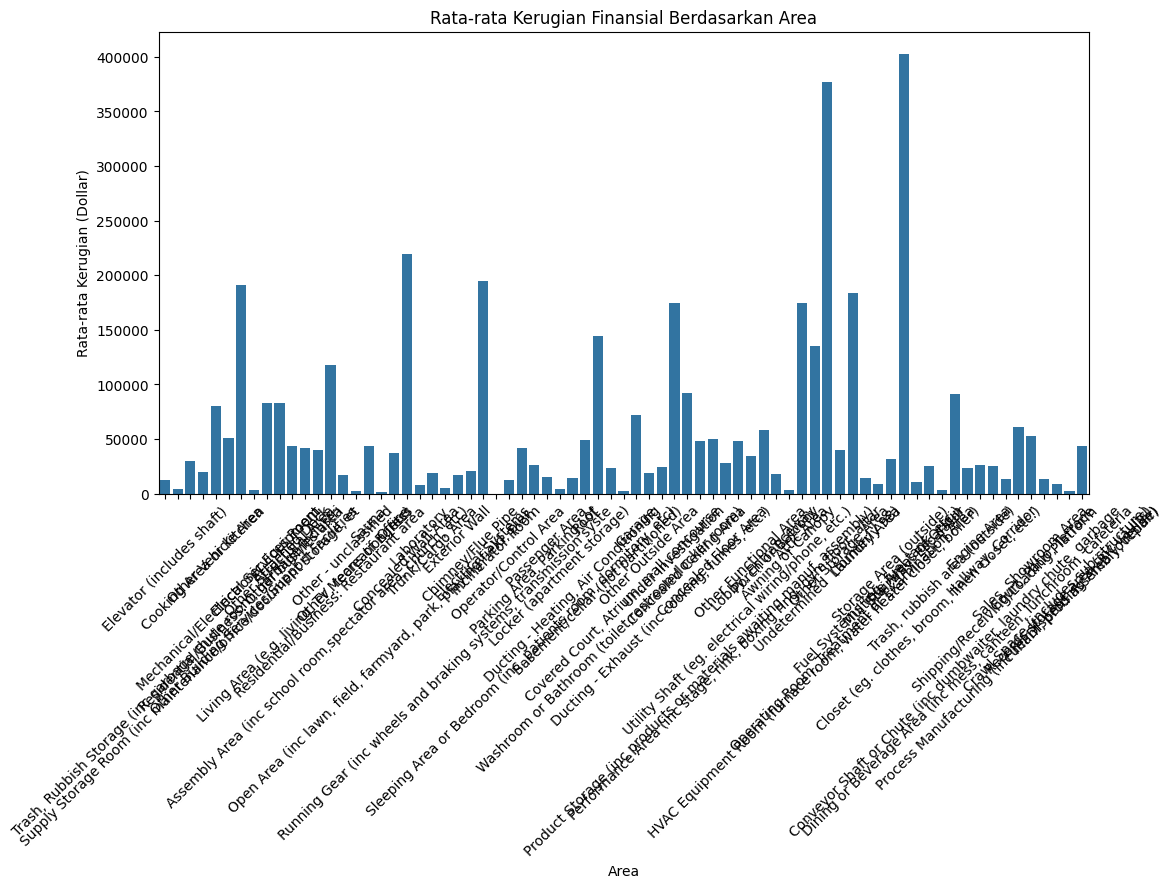

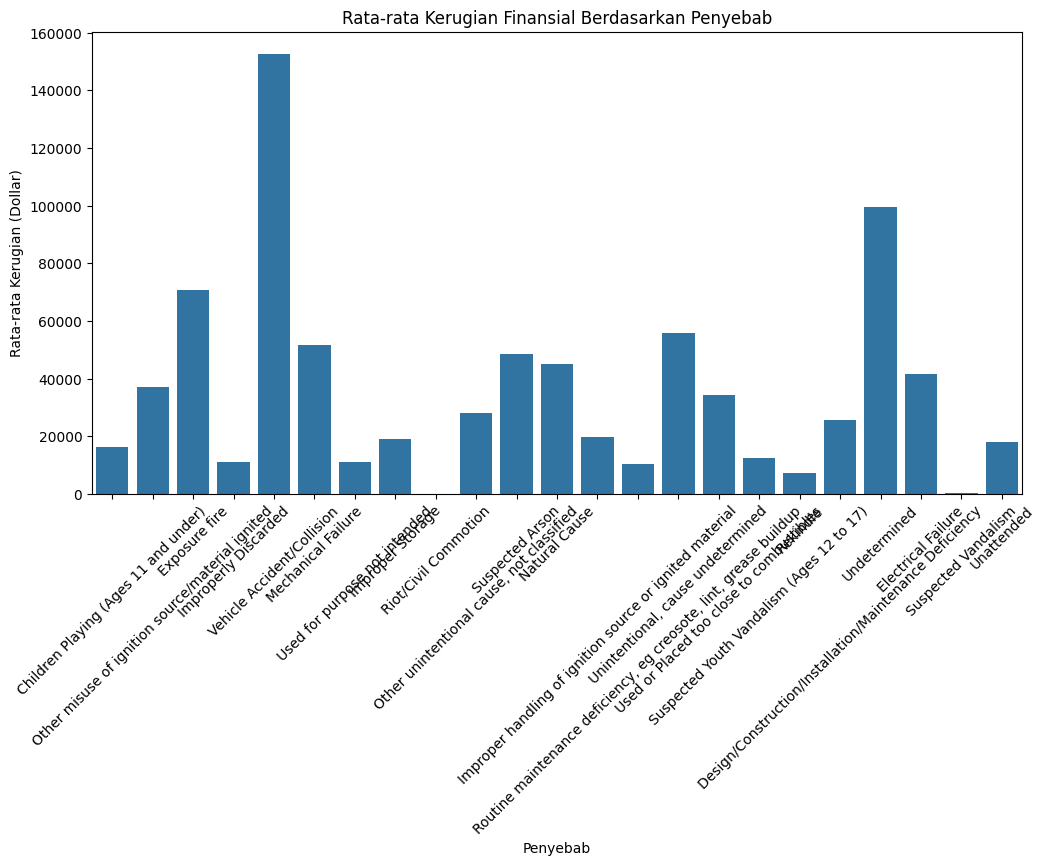

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Konversi ke Pandas DataFrame untuk visualisasi
avg_loss_by_area_pd = avg_loss_by_area.toPandas()
avg_loss_by_cause_pd = avg_loss_by_cause.toPandas()

# Plot Rata-rata kerugian berdasarkan Incident_Area
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_loss_by_area_pd, x="Area_of_origin", y="Avg_Dollar_Loss")
plt.title("Rata-rata Kerugian Finansial Berdasarkan Area")
plt.xlabel("Area")
plt.ylabel("Rata-rata Kerugian (Dollar)")
plt.xticks(rotation=45)
plt.show()

# Plot Rata-rata kerugian berdasarkan Possible_Cause
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_loss_by_cause_pd, x="Possible_Cause", y="Avg_Dollar_Loss")
plt.title("Rata-rata Kerugian Finansial Berdasarkan Penyebab")
plt.xlabel("Penyebab")
plt.ylabel("Rata-rata Kerugian (Dollar)")
plt.xticks(rotation=45)
plt.show()


1. MENGANALISIS BERAPA RATA-RATA KERUGIAN(DOLLAR) BERDASARKAN AREA KEBAKARAN DAN PENYEBAB KEBAKARAN (end)

2. MENGIDENTIFIKASI TREN ATAU POLA DARI TAHUN KE TAHUN UNTUK MENGANALISIS JUMLAH KEBAKARAN DAN KORBAN JIWA (start)

In [144]:
df_trend = fire_incidents.withColumn("Year", year(col("TFS_Arrival_Time"))) \
             .withColumn("Month", month(col("TFS_Arrival_Time"))) \
             .groupBy("Year", "Month") \
             .agg(
                 count("TFS_Arrival_Time").alias("Incident_Count"),
                 sum("Civilian_Casualties").alias("Total_Civilian_Casualties"),
                 sum("Count_of_Persons_Rescued").alias("Total_Persons_Rescued"),
                 sum("Estimated_Dollar_Loss").alias("Total_Estimated_Dollar_Loss"),
                 sum("Estimated_Number_Of_Persons_Displaced").alias("Total_Persons_Displaced")
             ) \
             .orderBy("Year", "Month")

# Tampilkan hasil agregasi
df_trend.show(10000)

+----+-----+--------------+-------------------------+---------------------+---------------------------+-----------------------+
|Year|Month|Incident_Count|Total_Civilian_Casualties|Total_Persons_Rescued|Total_Estimated_Dollar_Loss|Total_Persons_Displaced|
+----+-----+--------------+-------------------------+---------------------+---------------------------+-----------------------+
|2011|    1|           100|                        2|                    7|                    4011731|                   1124|
|2011|    2|           101|                       12|                   15|                    2927401|                   4403|
|2011|    3|           124|                        7|                    1|                   15018055|                   1247|
|2011|    4|            98|                        4|                    7|                    2941385|                   1825|
|2011|    5|           103|                       10|                    1|                    3836260| 

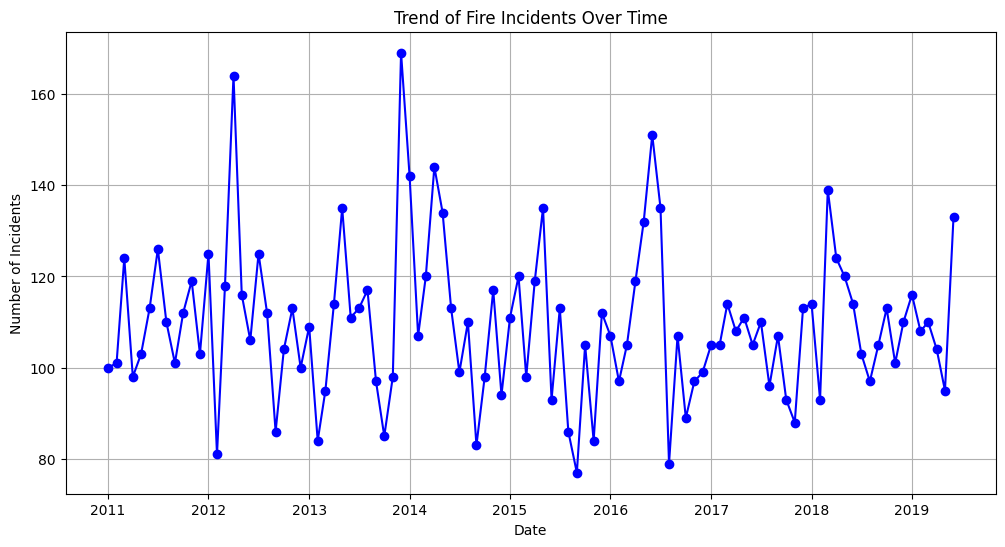

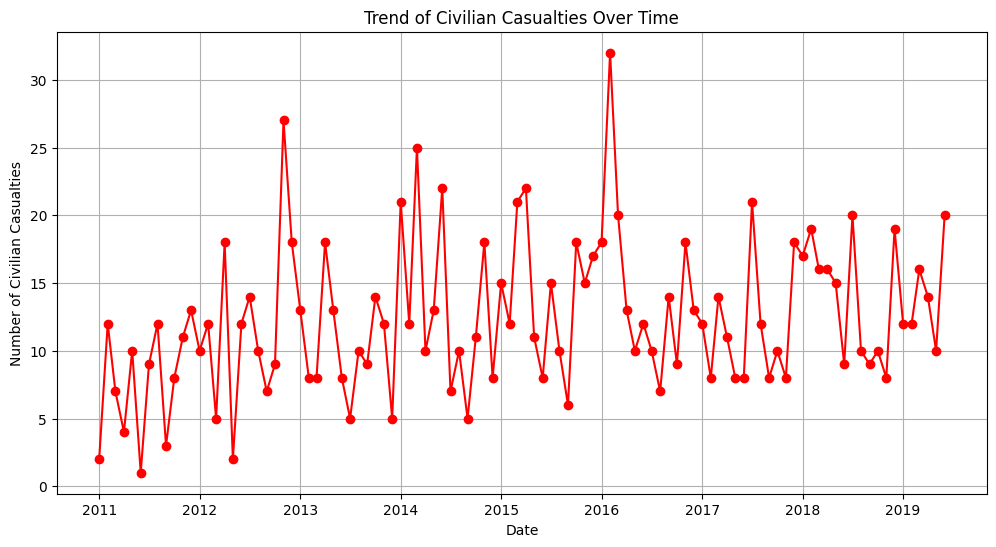

In [145]:
# Konversi DataFrame PySpark ke Pandas DataFrame
pd_df_trend = df_trend.toPandas()

# Buat kolom datetime dari Year dan Month untuk memudahkan plotting
pd_df_trend['Date'] = pd.to_datetime(pd_df_trend[['Year', 'Month']].assign(DAY=1))

# Plotting tren insiden kebakaran
plt.figure(figsize=(12, 6))
plt.plot(pd_df_trend['Date'], pd_df_trend['Incident_Count'], marker='o', linestyle='-', color='b')
plt.title('Trend of Fire Incidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()

# Plotting tren lainnya (misalnya, korban sipil)
plt.figure(figsize=(12, 6))
plt.plot(pd_df_trend['Date'], pd_df_trend['Total_Civilian_Casualties'], marker='o', linestyle='-', color='r')
plt.title('Trend of Civilian Casualties Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Civilian Casualties')
plt.grid(True)
plt.show()

2. MENGIDENTIFIKASI TREN ATAU POLA DARI TAHUN KE TAHUN UNTUK MENGANALISIS JUMLAH KEBAKARAN DAN KORBAN JIWA (end)

3. (1) ANALISIS KOMPARATIF UNTUK MEMBANDINGKAN BANYAK KEBAKARAN DAN KERUGIAN(DOLLAR) YANG TERJADI BERDASARKAN AREA TERJADINYA KEBAKARAN (start)

In [147]:
# Agregasi data berdasarkan lokasi
df_location_stats = fire_incidents.groupBy("Area_of_Origin") \
    .agg(
        count("TFS_Arrival_Time").alias("Incident_Count"),
        avg("Civilian_Casualties").alias("Avg_Civilian_Casualties"),
        avg("Count_of_Persons_Rescued").alias("Avg_Persons_Rescued"),
        avg("Estimated_Dollar_Loss").alias("Avg_Dollar_Loss"),
        avg("Estimated_Number_Of_Persons_Displaced").alias("Avg_Persons_Displaced")
    ) \
    .orderBy("Area_of_Origin")

# Tampilkan hasil agregasi
df_location_stats.show(truncate=False)

+----------------------------------------------------------------+--------------+-----------------------+--------------------+------------------+---------------------+
|Area_of_Origin                                                  |Incident_Count|Avg_Civilian_Casualties|Avg_Persons_Rescued |Avg_Dollar_Loss   |Avg_Persons_Displaced|
+----------------------------------------------------------------+--------------+-----------------------+--------------------+------------------+---------------------+
|Assembly Area (inc school room,spectator area, church, etc)     |14            |0.0                    |0.0                 |39950.0           |26.357142857142858   |
|Attached Deck                                                   |98            |0.07142857142857142    |0.030612244897959183|43150.255102040814|21.53061224489796    |
|Attic Area                                                      |64            |0.03125                |0.015625            |174460.9375       |64.796875      

<Figure size 1400x700 with 0 Axes>

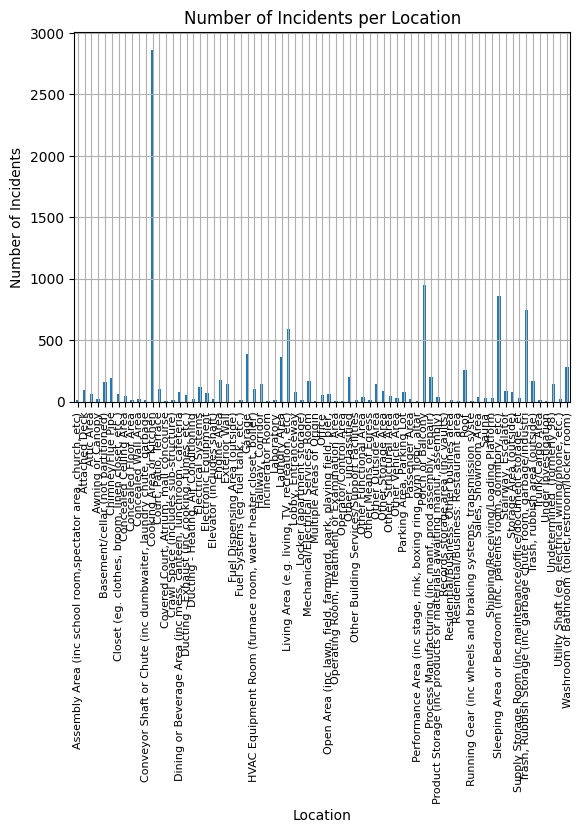

<Figure size 1400x700 with 0 Axes>

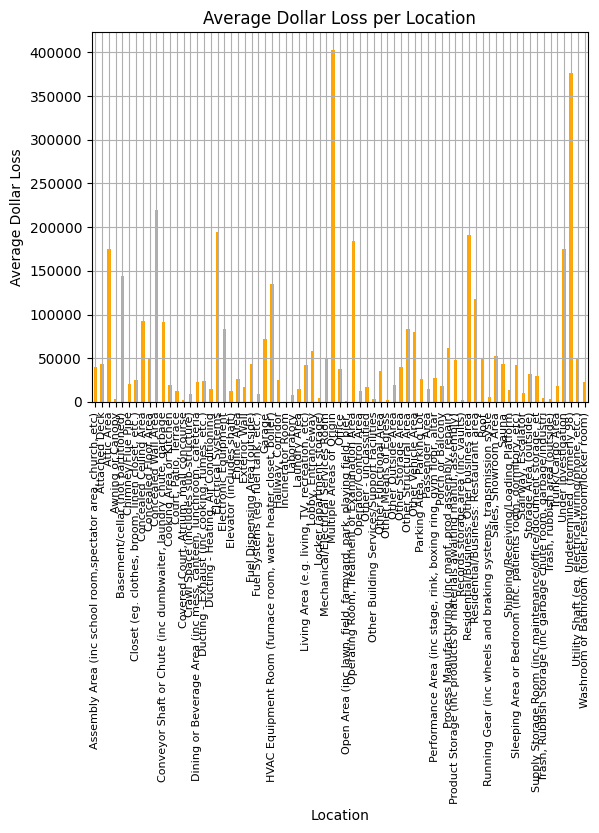

In [148]:
# Konversi DataFrame PySpark ke Pandas DataFrame
pd_df_location_stats = df_location_stats.toPandas()

# Visualisasi jumlah insiden per lokasi
plt.figure(figsize=(14, 7))
pd_df_location_stats.plot(kind='bar', x='Area_of_Origin', y='Incident_Count', legend=False)
plt.title('Number of Incidents per Location')
plt.xlabel('Location')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=90, fontsize=8)  # Menyesuaikan ukuran font
plt.grid(True)
plt.show()

# Visualisasi statistik lainnya (misalnya, rata-rata kerugian dolar)
plt.figure(figsize=(14, 7))
pd_df_location_stats.plot(kind='bar', x='Area_of_Origin', y='Avg_Dollar_Loss', legend=False, color='orange')
plt.title('Average Dollar Loss per Location')
plt.xlabel('Location')
plt.ylabel('Average Dollar Loss')
plt.xticks(rotation=90, fontsize=8)  # Menyesuaikan ukuran font
plt.grid(True)
plt.show()


3. (1) ANALISIS KOMPARATIF UNTUK MEMBANDINGKAN BANYAK KEBAKARAN DAN KERUGIAN(DOLLAR) YANG TERJADI BERDASARKAN AREA TERJADINYA KEBAKARAN (end)

3. (2) CLUSTERING MENGGUNAKAN K-MEANS (start)

<Figure size 1400x700 with 0 Axes>

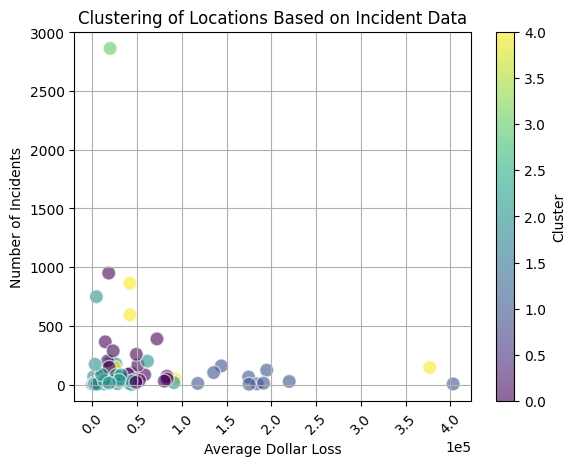

In [149]:

# Preprocessing data untuk clustering
features = ['Incident_Count', 'Avg_Civilian_Casualties', 'Avg_Persons_Rescued', 'Avg_Dollar_Loss', 'Avg_Persons_Displaced']
X = pd_df_location_stats[features]

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering dengan KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_scaled)
pd_df_location_stats['Cluster'] = kmeans.labels_

# Visualisasi hasil clustering
plt.figure(figsize=(14, 7))
scatter_plot = pd_df_location_stats.plot(kind='scatter', x='Avg_Dollar_Loss', y='Incident_Count', c='Cluster', colormap='viridis', alpha=0.6, edgecolors='w', s=100)
plt.title('Clustering of Locations Based on Incident Data')
plt.xlabel('Average Dollar Loss')
plt.ylabel('Number of Incidents')
plt.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Format the x-axis labels to be more readable (e.g., using scientific notation)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.show()

3. (2) CLUSTERING MENGGUNAKAN K-MEANS (end)